In [34]:
import pandas as pd

df_test = pd.read_csv(
    "eBay_ML_Challenge_Dataset_2021_train.tsv", 
    sep='\t', 
    header=0,
    nrows=50000)

# clean data
df_test["payment_datetime"] = pd.to_datetime(df_test["payment_datetime"], utc=True).dt.date
df_test["delivery_date"] = pd.to_datetime(df_test["delivery_date"]).dt.date
df_test = df_test[df_test["declared_handling_days"] >= 0]
df_test = df_test[df_test["carrier_min_estimate"] >= 0]
df_test = df_test[df_test["item_price"] <= 100]
df_test = df_test[df_test["weight"] <= 100]

# nomi = pgeocode.Nominatim('fr')
# df_test['buyer_zip'] = df_test['buyer_zip'].apply(lambda x: nomi.query_postal_code(x).longitude)
# df_test['item_zip'] = df_test['item_zip'].apply(lambda x: nomi.query_postal_code(x).longitude)  

In [35]:
df_test[0:5]

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,25454,3.0,2019-03-26 15:11:00.000-07:00,0,0.0,3,5,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5,1,LETTER,1
1,C2C,6727381,2.0,2018-06-02 12:53:00.000-07:00,0,3.0,3,5,11415-3528,62521,0,20.50,1,2018-06-01,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,B2C,18507,1.0,2019-01-07 16:22:00.000-05:00,0,4.5,3,5,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,B2C,4677,1.0,2018-12-17 16:56:00.000-08:00,0,0.0,3,5,90703,80022,1,35.50,1,2018-12-16,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,B2C,4677,1.0,2018-07-27 16:48:00.000-07:00,0,0.0,3,5,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5


In [38]:
from datetime import datetime

df_features = pd.DataFrame()
df_features["min"] = df_test["declared_handling_days"] + df_test["carrier_min_estimate"]
df_features["max"] = df_test["declared_handling_days"] + df_test["carrier_max_estimate"]
df_features["price"] = df_test["item_price"]
df_features["quantity"] = df_test["quantity"]
df_features["fee"] = df_test["shipping_fee"]
df_features["ship_id"] = df_test["shipment_method_id"]
df_features["weight"] = df_test["weight"] * df_test["weight_units"]


#for i in range(len(df_features['weight'])):
  #coords_1 = (df_test['buyer_zip'][i].latitude, df_test['buyer_zip'][i].longtitude)
  #coords_2 = (df_test['item_zip'][i].latitude, df_test['item_zip'][i].longtitude)
  #df_features['distnace'][i] = geopy.distance.vincenty(coords_1, coords_2).km


# coords_1 = (52.2296756, 21.0122287)
# coords_2 = (52.406374, 16.9251681)

# print geopy.distance.vincenty(coords_1, coords_2).km

# coordiates = nomi.query_postal_code("75013").latitude [longitude]

#df_features['buyer_zip'][0:5]

# get zip distance
# normalize shipping fee w weights?

df_labels = pd.DataFrame()
df_labels["result"] = df_test["delivery_date"] - df_test["payment_datetime"]
df_labels["result"] = (df_labels["result"]).dt.days

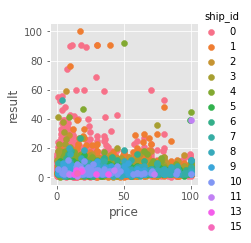

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_combined = df_features
df_combined["result"] = df_labels["result"]

plt.style.use('ggplot') 
sns.FacetGrid(df_combined, 
    hue="ship_id").map(plt.scatter, "price", "result").add_legend()

plt.show()

In [32]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
)
from sklearn.neural_network import MLPClassifier

classifiers = {
    #"BernoulliNB": BernoulliNB(),
    #"ComplementNB": ComplementNB(),
    #"MultinomialNB": MultinomialNB(),
    # "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    # "LogisticRegression": LogisticRegression(max_iter=1000),
    #"AdaBoostClassifier": AdaBoostClassifier(),
    # "MLPClassifier": MLPClassifier(max_iter=1000),
    #"SGDClassifier": SGDClassifier(),
}


In [41]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

features = sparse.csr_matrix(df_features)
labels = df_labels['result'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.33, 
    random_state = 1234)
        

for name, sklearn_clf in classifiers.items():
    clf = sklearn_clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(F"{accuracy:.2%} - {name}")

def random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 200)
    clf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy of Random Forest classifier on training set: {:.2f}'
          .format(clf.score(X_train, y_train)))
    print('Accuracy of Random Forest classifier on test set: {:.2f}'
          .format(clf.score(X_test, y_test)))
    
    cf_mat = confusion_matrix(y_test, y_pred)
    confusion = pd.DataFrame(data = cf_mat)
    print(confusion)
    print(classification_report(y_test, y_pred))
    
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 200)
    clf = LogisticRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy of Logistic regression classifier on training set: {:.2f}'
          .format(clf.score(X_train, y_train)))
    print('Accuracy of Logistic regression classifier on test set: {:.2f}'
          .format(clf.score(X_test, y_test)))
    cf_mat = confusion_matrix(y_test, y_pred)
    confusion = pd.DataFrame(data = cf_mat)
    print(confusion)
    print(classification_report(y_test, y_pred))
    
random_forest(features,labels)
log_reg(features, labels)




99.90% - DecisionTreeClassifier
97.05% - RandomForestClassifier
Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.97
    0   1     2     3     4     5    6    7    8    9   ...  38  39  40  41  \
0    1   4     0     0     0     0    0    0    0    0  ...   0   0   0   0   
1    0  69     6     0     0     0    0    0    0    0  ...   0   0   0   0   
2    0   0  1562     0     0     0    0    0    0    0  ...   0   0   0   0   
3    0   0     0  2872     0     0    0    0    0    0  ...   0   0   0   0   
4    0   0     0     0  2450     0    0    0    0    0  ...   0   0   0   0   
5    0   0     0     0     0  1644    0    0    0    0  ...   0   0   0   0   
6    0   0     0     0     0     0  892    0    0    0  ...   0   0   0   0   
7    0   0     0     0     0     0    1  534    0    0  ...   0   0   0   0   
8    0   0     0     0     0     1    0   13  320    1  ...   0   0   0   0   
9    0   0     0     0     0    

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.

Accuracy of Logistic regression classifier on training set: 0.59
Accuracy of Logistic regression classifier on test set: 0.59
    0   1     2     3     4    5    6    7   8   9   ...  36  37  38  39  40  \
0    0   0     5     0     0    0    0    0   0   0  ...   0   0   0   0   0   
1    0   0    75     0     0    0    0    0   0   0  ...   0   0   0   0   0   
2    0   0  1109   451     0    0    0    0   0   1  ...   0   0   0   0   0   
3    0   0   185  2435   250    0    0    0   0   2  ...   0   0   0   0   0   
4    0   0    11   431  1944   56    3    0   0   5  ...   0   0   0   0   0   
5    0   0    12    32   861  638   90    1   0   8  ...   0   0   0   0   0   
6    0   0     2     8   179  385  297   14   1   5  ...   0   0   0   0   0   
7    0   0     1     9    37  178  247   57   2   2  ...   0   0   0   0   0   
8    0   0     1     0    13   83   92  124  16   6  ...   0   0   0   0   0   
9    0   0     0     1     6   21   73   85  39   3  ...   0   0   0   0  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-define